In [1]:
# !pip install feather-format

In [2]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
import feather

# Functions

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        if col!=TARGET:
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
#                     if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                         df[col] = df[col].astype(np.float16)
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Load data

Meter data

In [4]:
path = '../data'

In [7]:
df_type = 'test'
df = pd.read_csv(f'{path}/ashrae/{df_type}.csv')

df["local_time"] = pd.to_datetime(df["timestamp"])
df['row_id'] = df.index

df.to_feather(f'{path}/Prepared_data/{df_type}.feather')

d_types = {'building_id': np.int16,
          'meter': np.int8}

for feature in d_types:
    df[feature] = df[feature].astype(d_types[feature])

gc.collect()

0

Cities data

In [6]:
cities = pd.read_csv(f'{path}/cities_info.csv')
cities['location'] = cities['location'].str.lower()
cities['utc'] = cities['utc'].apply(lambda x: x[0:3])
cities['utc'] = cities['utc'].astype(float)

site_mapping = cities['location'].to_dict()

Building metadata

In [7]:
building = pd.read_csv(f'{path}/ashrae/building_metadata.csv')
d_types = {'building_id': np.int16,
          'site_id': np.int8,
          'primary_use': 'category',
          'square_feet': np.int32,
          'year_built': np.float32,
          'floor_count': np.float32}

for feature in d_types:
    building[feature] = building[feature].astype(d_types[feature])
    
building['site_id'] = building['site_id'].replace({8:0,11:7})

building = pd.merge(building, cities[['site_id','utc']], how='left')

Predict floor_count

In [8]:
primary_use = pd.get_dummies(building['primary_use'])
primary_use = primary_use[primary_use.columns[primary_use.sum().gt(10)]]
building = pd.concat([building,primary_use],axis=1)

cols = ['Office','Public services','Education','Entertainment/public assembly',
        'Lodging/residential','square_feet']
X = building[building['square_feet'].lt(80000)].dropna(subset=['floor_count'])[cols]
Y = building[building['square_feet'].lt(80000)].dropna(subset=['floor_count'])['floor_count']

poly = PolynomialFeatures().fit(X)
X = poly.transform(X)[:,poly.powers_.max(axis=1)==1]

lm = LinearRegression(fit_intercept=True).fit(X,Y)
print(lm.score(X,Y).round(2))

X = poly.transform(building[cols])[:,poly.powers_.max(axis=1)==1]
pred = lm.predict(X)

0.44


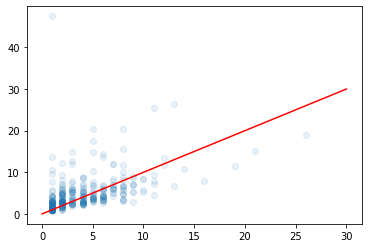

In [9]:
plt.scatter(x=building[building['floor_count'].notna()]['floor_count'],
            y=pred[building['floor_count'].notna()],alpha=0.1)
plt.plot([0,30],[0,30],c='r')
plt.show()

Filling NA and adding `square_feet_log`, inspiration from https://www.kaggle.com/tunguz/simple-linear-regression-benchmark

In [10]:
building['new_floor_count'] = np.where(building['floor_count'].isna(),pred,building['floor_count'])
building['new_year_built'] = building['year_built'].fillna(building['year_built'].mean())
building['square_feet_log'] = np.log1p(building['square_feet']**0.5)

building = building[['site_id','building_id','primary_use','square_feet','year_built',
                     'floor_count','utc','new_floor_count','new_year_built','square_feet_log']]

In [11]:
del lm, X, Y, poly, pred, d_types

Merge df with building 

In [12]:
df = pd.merge(df,building)

# Add time variables including holidays 

https://www.kaggle.com/c/ashrae-energy-prediction/discussion/115256#latest-671174

In [13]:
import holidays.holidays as holidays
ca_holidays = holidays.Canada()

In [14]:
hldys = pd.read_csv(f'{path}/dates_related/public_holiday.csv')
hldys['Date'] = pd.to_datetime(hldys['Date'], dayfirst=True)
hldys = hldys[~hldys['Holiday'].str.contains('Robert E. Lee')]

In [15]:
hldys_country = hldys[hldys['Type'].isin(cities['country'])]
hldys_country = hldys_country.groupby(['Date','Type'])['Holiday'].first().unstack(level=1)
hldys_country.columns = ['IR','UK','US']
hldys_country = hldys_country.reindex(pd.date_range('2016-01-01','2018-12-31',freq='1D')).fillna('')
hldys_country['CA'] = pd.Series(hldys_country.index).apply(lambda x: ca_holidays.get(x, default='')).values
hldys_country = hldys_country!=''

In [16]:
hldys_state = hldys[hldys['Type'].isin(cities['state'])]
hldys_state = hldys_state.groupby(['Date','Type'])['Holiday'].first().unstack(level=1)
hldys_state = hldys_state.reindex(pd.date_range('2016-01-01','2018-12-31',freq='1D')).fillna('')
hldys_state = hldys_state!=''

In [17]:
df['is_holiday'] = np.nan
for s in df['site_id'].unique():
    print('Site',s,'done.')
    country = cities[cities['site_id'].eq(s)]['country'].values[0]
    rows = df['site_id'].eq(s)
    df.loc[rows,'is_holiday'] = hldys_country.loc[df.loc[rows,'local_time'].dt.date,country].values
    if country =='US':
        state = cities[cities['site_id'].eq(s)]['state'].values[0]
        if state not in ['washingtondc','minnesota','pennsylvania']:
            df.loc[rows,'is_holiday'] = df.loc[rows,'is_holiday'] | \
                                           hldys_state.loc[df.loc[rows,'local_time'].dt.date,state].values

Site 0 done.
Site 1 done.
Site 2 done.
Site 3 done.
Site 4 done.
Site 5 done.
Site 6 done.
Site 7 done.
Site 9 done.
Site 10 done.
Site 12 done.
Site 13 done.
Site 14 done.
Site 15 done.


In [18]:
del hldys_state, hldys, hldys_country, state, country
gc.collect()

2677

# Add other time features (cos sin) before moving to UTC

In [19]:
df['weekday_cos'] = np.cos(2*np.pi*(df['local_time'].dt.weekday + df['local_time'].dt.hour/24)/7)
df['weekday_sin'] = np.sin(2*np.pi*(df['local_time'].dt.weekday + df['local_time'].dt.hour/24)/7)

df['weekday'] = (df['local_time'].dt.weekday//5).astype(int)*1.0
 
df['hour_cos'] = np.cos(2*np.pi*df['local_time'].dt.hour/24)
df['hour_sin'] = np.sin(2*np.pi*df['local_time'].dt.hour/24)

df['year_cos'] = np.cos(2*np.pi*(df['local_time'].dt.dayofyear)/365)
df['year_sin'] = np.sin(2*np.pi*(df['local_time'].dt.dayofyear)/365)

df['night_time'] = (df['local_time'].dt.hour < 6) | (df['local_time'].dt.hour > 21)
df['morning'] = (df['local_time'].dt.hour >= 6) & (df['local_time'].dt.hour <= 10)
df['afternoon'] = (df['local_time'].dt.hour >= 11) & (df['local_time'].dt.hour <= 18)
df['evening'] = (df['local_time'].dt.hour >= 19) & (df['local_time'].dt.hour <= 22)

In [20]:
gc.collect()

98

# Add Day saving time feature

In [21]:
day_savings = pd.read_csv(f'{path}/dates_related/daytime_savings.csv')
day_savings_df = pd.DataFrame([],index=pd.date_range('2016-01-01','2018-12-31'))

In [22]:
for country in day_savings['country'].unique():
    day_savings_df[country]=False
    for _,row in day_savings[day_savings['country']==country].iterrows():
        day_savings_df[country] = day_savings_df[country].values | pd.Series(day_savings_df.index).between(row['start'],row['end']).values

In [23]:
for s in df['site_id'].unique():
    print('Site',s,'done.')
    country = cities[cities['site_id'].eq(s)]['country'].values[0]
    rows = df['site_id'].eq(s)
    df.loc[rows,'is_day_saving'] = day_savings_df.loc[df.loc[rows,'local_time'].dt.date,country].values

Site 0 done.
Site 1 done.
Site 2 done.
Site 3 done.
Site 4 done.
Site 5 done.
Site 6 done.
Site 7 done.
Site 9 done.
Site 10 done.
Site 12 done.
Site 13 done.
Site 14 done.
Site 15 done.


In [24]:
del day_savings, day_savings_df, rows
gc.collect()

208

# Change time to UTC

In [25]:
for site in df['site_id'].unique():
    rows = df['site_id'].eq(site)
    offset = df.loc[rows,'utc'].values[0]
    df.loc[rows,'utc_time'] = df.loc[rows,'local_time'] - pd.DateOffset(hours=offset)
    print("Site", site, "done.")

Site 0 done.
Site 1 done.
Site 2 done.
Site 3 done.
Site 4 done.
Site 5 done.
Site 6 done.
Site 7 done.
Site 9 done.
Site 10 done.
Site 12 done.
Site 13 done.
Site 14 done.
Site 15 done.


In [26]:
if df_type =='train':
    for site in df['site_id'].unique():
        if site != 13:
            subset = df.loc[df['site_id'].eq(site)]
            subset = subset.groupby(subset['local_time'].dt.hour)['meter_reading'].mean()
            subset = (subset-subset.min())/(subset.max()-subset.min())
            subset.plot(label=site)
    plt.legend()
    plt.show()

In [27]:
if df_type =='train':
    for primary_use in df['primary_use'].unique():
        subset = df.loc[df['primary_use'].eq(primary_use)]
        subset = subset.groupby(subset['local_time'].dt.hour)['meter_reading'].mean()
        subset = (subset-subset.min())/(subset.max()-subset.min())
        subset.plot(label=primary_use)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

# Replace large outlier values

In [28]:
TARGET = 'meter_reading'

In [29]:
if df_type=='train':
    grouping = df['building_id'].astype(str) +'_'+\
                 df['utc_time'].dt.month.astype(str) +'_'+\
                 df['meter'].astype(str) 

    temp_df = df.groupby(grouping)[TARGET].apply(lambda x: int(np.percentile(x,99)))
    temp_df = temp_df.to_dict()

    modified_meter_reading = grouping.map(temp_df)
    df[TARGET] = np.where(df[TARGET]>modified_meter_reading,
                          modified_meter_reading,
                          df[TARGET])

# Remove suspiciously constant data

Remove data until a certain threshold for electricity meter readings based on : 
- https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113054#656588
- https://www.kaggle.com/c/ashrae-energy-prediction/discussion/116773#latest-675367

In [30]:
if df_type =='train':
    s = df.sort_values('local_time').groupby(['building_id','meter'])['meter_reading'].transform('cumsum')
    s = s[df.index]

    df['suspicious_1'] = (s.lt(500) & df['meter'].eq(0)) | \
                       (df['building_id'].le(104) & 
                        df['local_time'].dt.dayofyear.lt(140) & 
                        df['meter_reading'].eq(0))

    df['suspicious_1'] = df['suspicious_1'].astype(np.int16)

    df.groupby('building_id')['suspicious_1'].sum().plot()
    plt.title("Number of points removed by building id")
    plt.show()


In [31]:
if df_type =='train':
    df = df.sort_values(['building_id','meter','utc_time'])
    group_id = df.groupby(['building_id','meter'])['meter_reading'].diff().ne(0).cumsum()
    same_value_in_a_row = group_id.groupby(group_id).transform('size')
    
    # Suspicious if more than 5 non-zero values in a row (for all meters) 
    # or 24 values in a row (including 0) if electricity
    df['suspicious_2'] = same_value_in_a_row.gt(5)*df['meter_reading'].ne(0)
    df['suspicious_2'] = df['suspicious_2'].astype(np.int16)
    
    df.groupby('building_id')['suspicious_2'].sum().plot()
    plt.title("Number of points removed by building id")
    plt.show()
    
    df['suspicious_3'] = df['meter_reading'].eq(0)*df['meter'].eq(0)
    df['suspicious_3'] = df['suspicious_3'].astype(np.int16)
        
    del group_id, same_value_in_a_row

In [32]:
to_drop = [col for col in ['local_time','timestamp'] if col in df.columns]
df = df.drop(columns=to_drop)
del to_drop
gc.collect()

100

# Replace categorical features

In [33]:
df['meter'] = df['meter'].astype('category')
df['is_holiday'] = df['is_holiday'].astype('category')
df[['night_time','morning','afternoon','evening']]= df[['night_time','morning','afternoon','evening']].astype('category')
df['weekday'] = df['weekday'].astype('category')
df['is_day_saving'] = df['is_day_saving'].astype('category')
df['site_id'] = df['site_id'].astype('category')

# Add age of building

In [34]:
df['age'] = df['utc_time'].dt.year - df['year_built'] 

# Merge with weather

In [35]:
weather = feather.read_dataframe(f'{path}/Prepared_data/weather_bis.feather')

if df_type =='test':
    weather = weather[weather['timestamp'].dt.year>2016].copy()
else:
    weather = weather[weather['timestamp'].dt.year<=2016].copy()

    
df = pd.merge(df, weather, how='left', left_on=['site_id','utc_time'], right_on=['site_id','timestamp'])
del weather
gc.collect()

df.drop(columns='timestamp',inplace=True)

# Reduce memory

In [36]:
for f in ['primary_use','is_day_saving','is_holiday','meter','site_id']:
    df[f] = df[f].astype('category')
    gc.collect()

for col in df.columns:
    if df[col].dtype in ['float64','float32','float16']:
        print(col)
        df[col] = df[col].round(4)
        gc.collect()
        
gc.collect()

year_built
floor_count
utc
new_floor_count
new_year_built
square_feet_log
weekday_cos
weekday_sin
hour_cos
hour_sin
year_cos
year_sin
age
air_temperature
cloud_coverage
dew_temperature
precip_depth_1_hr
sea_level_pressure
wind_speed
new_sea_level_pressure
new_dew_temperature
new_wind_speed
new_cloud_coverage
new_precip_depth_1_hr
new_air_temperature
uvIndex
cloudCover
humidity
latitude
longitude
irradiance
irradiance_cloud
feels_like
new_feels_like
altitude
azimuth
radiation
air_temperature_mean_lag72
air_temperature_max_lag72
air_temperature_min_lag72
air_temperature_std_lag72
cloudCover_mean_lag72
cloudCover_max_lag72
cloudCover_min_lag72
cloudCover_std_lag72
beaufort_scale
wind_direction_cos
wind_direction_sin
new_wind_direction_cos
new_wind_direction_sin


0

In [37]:
# do_not_convert = ['category','datetime64[ns]','object','boolean']
# original = df.copy()
# df = reduce_mem_usage(df)

# for col in list(df):
#     if df[col].dtype.name not in do_not_convert:
#         if (df[col]-original[col]).sum()!=0:
#             df[col] = original[col]
#             print('Bad transformation', col)
# del original

do_not_convert = ['category','datetime64[ns]','object','boolean']
original = df.copy()
TARGET = 'meter_reading_log'
df = reduce_mem_usage(df)

for col in list(df):
    if df[col].dtype.name not in do_not_convert:
        if (df[col]-original[col]).abs().max()>0.01:
            print('Bad transformation', col)
            print((df[col]-original[col]).abs().max())
            df[col] = original[col].copy()
del original

Mem. usage decreased to 9384.76 Mb (40.4% reduction)


In [38]:
# df['floor_count'] = df['floor_count'].astype(np.int32)
# df['year_built'] = df['year_built'].astype(np.int32)
# df['utc'] = df['utc'].astype(np.int32)

df = df.reset_index(drop=True)
gc.collect()

20

# Save data

In [39]:
%%time
df.to_feather(f'{path}/Prepared_data/{df_type}_filled_na_light.feather')

CPU times: user 16.1 s, sys: 14.4 s, total: 30.5 s
Wall time: 17 s
